# Guided Project : Building a Spam Filter with Niave Bayes

Our goal in this project is to build a spam filter for SMS messages. To classify messages as spam or non-spam. To "teach" the computer how to classify messages, we will use the multinomial Naive Bayes algorithm along with a dataset of 5,572 SMS messages that are already classified by humans.

The dataset was put togetther by Tiago A. Almedia and Jose Maria Gomez Hidalgo, and it can be downloaded from [The UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/sms+spam+collection). The data collection process is described in more details on [this page](http://www.dt.fee.unicamp.br/~tiago/smsspamcollection/#composition), where the author's papers are.

In [1]:
import pandas as pd

In [2]:
sms_spam_dataset = pd.read_csv('SMSSpamCollection',sep='\t',header=None)

In [3]:
sms_spam_dataset.columns = ['Label','SMS']

# Exploring the dataset

In [4]:
sms_spam_dataset.head(3)

,Label,SMS
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...


-ham label means the message is not spam
spam label means the message is spam

In [5]:
sms_spam_dataset.shape

(5572, 2)

In [6]:
sms_spam_dataset[sms_spam_dataset['Label']=='spam'].shape[0]/sms_spam_dataset.shape[0]*100

13.406317300789663

In [7]:
sms_spam_dataset[sms_spam_dataset['Label']=='ham'].shape[0]/sms_spam_dataset.shape[0]*100

86.59368269921033

In [8]:
sms_spam_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
Label    5572 non-null object
SMS      5572 non-null object
dtypes: object(2)
memory usage: 87.1+ KB


We could see that the percentage of spam messages in the dataset is about 13% while messages that are not spam are about 87%. It seems we have more messages that are not spam than those that are spam. This makes the sample representative since in practice most messages that people receive are ham.Also we could see that there are no null values

# Training and Test Set

We are now going to split our dataset into a training and a test set, where the training set accounts for 80% of the data, and the test set for the remaining 20%. After building our spam filte, wee need to test it with data from the dataset which have not been used to train the data( hence the need to have a separated data from the training data)

In [9]:
# Randomize the dataset
randomized_data = sms_spam_dataset.sample(frac=1,random_state=1)
# Calculating index forsplit 
train_test_index = round(len(randomized_data)*0.8)
# Training/ Test split
train_set = randomized_data[:train_test_index].reset_index(drop=True)
test_set = randomized_data[train_test_index:].reset_index(drop=True)

We are now going to analyze the percentge of spam and ham messages in the training and test sets. We expect the percentages to be clolsoe to what we have in the full dataset, where about 87% of the messages are ham, and the remaining 13% are spam.

In [10]:
print(train_set.shape)
print(test_set.shape)

(4458, 2)
(1114, 2)


In [11]:
round(test_set[test_set['Label']=='ham'].shape[0]/test_set.shape[0] *100)

87

In [12]:
round(test_set[test_set['Label']=='spam'].shape[0]/test_set.shape[0]*100)

13

In [13]:
train_set[train_set['Label']=='ham'].shape[0]/train_set.shape[0]*100

86.54104979811575

The results look good we will now move on to cleaning the dataset

# Data Cleaning 

To calculate all the probabilities required by the algorithm, we will first need to perform a bit of data cleaning to bring the data in a format that will allow us to extract easily all the information we need. Essentially, we want to bring the data to this format:

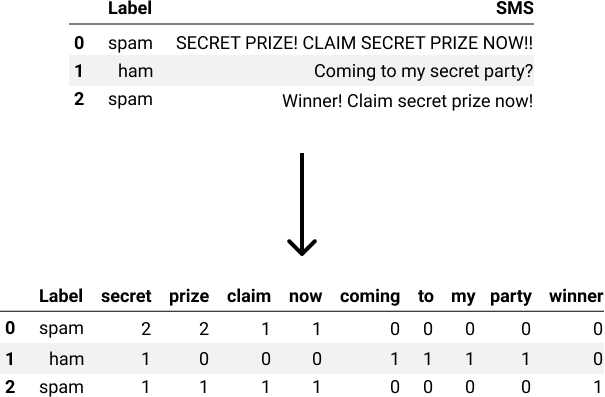

In [14]:
from IPython.display import Image
Image('spam first image dataquest.png')

# Letter Case and Punctuation
We will begin with removing all the punctuation and bringing every letter to lowe case.

In [15]:
# Before cleaning 
train_set.head()

,Label,SMS
0,ham,"Yep, by the pretty sculpture"
1,ham,"Yes, princess. Are you going to make me moan?"
2,ham,Welp apparently he retired
3,ham,Havent.
4,ham,I forgot 2 ask ü all smth.. There's a card on ...


In [16]:
import re
train_set['SMS'] = train_set['SMS'].str.replace('\W',' ')

In [17]:
# After cleaning
train_set.head(3)

,Label,SMS
0,ham,Yep by the pretty sculpture
1,ham,Yes princess Are you going to make me moan
2,ham,Welp apparently he retired


In [18]:
train_set['SMS'] = train_set['SMS'].str.lower()

In [19]:
train_set['SMS'].str.isupper().sum()

0

# Creating the vocabulary

Let's now move to creating the vocabulary, which in this context means a list with all the unique words in our training set

In [20]:
train_set['SMS'] = train_set['SMS'].str.split()

In [21]:
vocabulary = []
for rows in train_set['SMS']:
    for i in rows:
        vocabulary.append(i)
vocab_set = set(vocabulary)
train_vocab_list = list(vocab_set)
len(train_vocab_list)


7783

It looks like there are 7,783 unique words in all the messages of our training set

# The Final Training Set

We are now going to use the vocabulary we just created to make the data transformation we want

In [22]:
word_counts_per_sms = {unique_word: [0]* len(train_set['SMS']) for unique_word in train_vocab_list}
for index,sms in enumerate(train_set['SMS']):
    for word in sms:
        word_counts_per_sms[word][index] += 1
        
      

In [23]:
word_counts_per_sms_df = pd.DataFrame(word_counts_per_sms)

In [24]:
word_counts_per_sms_df.shape

(4458, 7783)

In [25]:
train_label = pd.concat([train_set,word_counts_per_sms_df],axis=1)

In [26]:
train_label.head()

,Label,SMS,0,00,000,000pes,008704050406,0089,01223585334,02,...,zindgi,zoe,zogtorius,zouk,zyada,é,ú1,ü,〨ud,鈥
0,ham,"[yep, by, the, pretty, sculpture]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ham,"[yes, princess, are, you, going, to, make, me,...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ham,"[welp, apparently, he, retired]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ham,[havent],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ham,"[i, forgot, 2, ask, ü, all, smth, there, s, a,...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,0,0


# Calculating Constants First

We are now done with cleaning the training set, and we can begin creating the spam filter. The Naive Bayes algorithm will need to answer these two probability questions to be able to classify new messages 

In [27]:
from IPython.display import SVG
SVG('spam seond image.svg')
#SVG('spam second image.svg')

Same applies to ham 

Also, to calculate P($w_{i}$|Spam) and P($w_{i}$|ham) inside the formulas above, we will need to use these equations:


P($w_{i}$|Spam) = N($w_{i}|Spam$) + alpha/N($_{Spam}$) + alpha * N($_{Vocabulary}$)

Same applies to ham

Some of the terms in the four equations above will have the same value for every new message.We can calculate the value of these terms once and avoid doing the computations again when new messages comes in. Below, we will use our training set to calculate:
- P(Spam) and P(Ham)
- N($_{Spam}$),N($_{Ham}$,N($_{Vocalbulary)}$

We will also use Laplace smoothning and set alpha to 1

In [28]:
train_label_set = train_label
# calculating the probability of non spam messages in the data set P(Spam)and P(Ham)
p_ham= len(train_label_set[train_label_set['Label']=='ham'])/len(train_label_set)
p_spam = len(train_label_set[train_label_set['Label']=='spam'])/len(train_label_set)

In [29]:
#Isolating spam and ham messages 
train_spam = train_label_set[train_label_set['Label']=='spam']
train_ham = train_label_set[train_label_set['Label']== 'ham']

In [30]:
n_spam = (train_spam['SMS'].apply(len)).sum() # sum numbers of spam words
n_spam

15190

In [31]:
train_ham_len = train_ham['SMS'].apply(len) #numbers of ham words
n_ham = train_ham_len.sum()

In [32]:
# numbers of vocabulary
n_vocabulary = len(train_vocab_list)
n_vocabulary
# Laplace smoothning
alpha = 1

In [33]:
train_spam.head(2)

,Label,SMS,0,00,000,000pes,008704050406,0089,01223585334,02,...,zindgi,zoe,zogtorius,zouk,zyada,é,ú1,ü,〨ud,鈥
16,spam,"[freemsg, why, haven, t, you, replied, to, my,...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18,spam,"[congrats, 2, mobile, 3g, videophones, r, your...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
# Initiate parameters
parameters_spam = {unique_word_spam:0 for unique_word_spam in train_vocab_list}
parameters_ham = {unique_word: 0 for unique_word in train_vocab_list}
# calculate parameters
for word in train_vocab_list:
    n_word_given_spam = train_spam[word].sum() # train_spam already defined in a cell above
    p_word_given_spam = (n_word_given_spam +alpha)/((n_spam)+(alpha * n_vocabulary))
    parameters_spam[word]= p_word_given_spam
for word in train_vocab_list:
    n_word_given_ham = train_ham[word].sum() # train_ham already defined in a cell above
    p_word_given_ham = (n_word_given_ham+alpha)/((n_ham)+(alpha*n_vocabulary))
    parameters_ham[word] = p_word_given_ham

# Classifying A New Message

Now that we have all our parameters calculated, we can start creating the spam filter. The spam filter can be understood as a function that:
- Takes in as input a new message ($w_{1}$,$w_{2}$,$w_{3}$,.....,$w_{n}$)
- Calculates P(Spam|$w_{1}$,$w_{2}$,....,$w_{n}$)
- Compares the values of P(Spam|$w_{1}$,$w_{2}$,...,$w_{n}$) and P(Ham|$w_{1}$,$w_{2}$,...,$w_{n}$)
- If P(Ham|$w_{1}$,$w_{2}$,...,$w_{n}$) > P(Spam|$w_{1}$,$w_{2}$,...,$w_{n}$), then the message is classified as ham
- If P(Ham|$w_{1}$,$w_{2}$,...,$w_{n}$) < P(Spam|$w_{1}$,$w_{2}$,...,$w_{n}$), then the message is classdified as spam
- If P(Ham|$w_{1}$,$w_{2}$,...,$w_{n}$) == P(Spam|$w_{1}$,$w_{2}$,...,$w_{n}$), then the algorithm may request human help.

In [35]:
import re # regex or regular expression
def classify(message):
    message = re.sub('\W',' ',message)
    message = message.lower() # to avoid discrepancies due to capitalization
    message = message.split() # split each string at white space into one single list at 
    p_spam_given_message = p_spam
    p_ham_given_message = p_ham
    for word in message:
        if word in parameters_spam:
            p_spam_given_message *= parameters_spam[word] 
    for word in message:
            if word in parameters_ham:
                p_ham_given_message *= parameters_ham[word]
    p_ham_given_message *= p_ham
    print('P(Spam|message):',p_spam_given_message)
    print('P(Ham|message):',p_ham_given_message)
    if p_ham_given_message > p_spam_given_message:
        print('Label: Ham')
    elif p_spam_given_message > p_ham_given_message:
        print('Label: Spam')
    else:
        print('Hey humam there is equal probabilities,please can you use your brain to classidy this!')
        

In [36]:
classify('Winner!! This is the secret code to unlock the money: C3421')

P(Spam|message): 1.3481290211300841e-25
P(Ham|message): 1.6761312954755437e-27
Label: Spam


In [37]:
classify("Sounds good, Tom, then see u there")

P(Spam|message): 2.4372375665888117e-25
P(Ham|message): 3.1912275500820184e-21
Label: Ham


# Measurung the Spam Filter's Accuracy

The two results above looks promising, but let us see how well the filter does on our test set,wgich has 1,114 messages.

We will start by writing a function that returns classification labels instead of printing them

In [38]:
def classify_test_set(message):
    message = re.sub('\W',' ',message)
    message = message.lower()
    message = message.split()
    p_spam_given_message = p_spam
    p_ham_given_message = p_ham
    for word in message:
        if word in parameters_spam:
            p_spam_given_message *= parameters_spam[word]
        if word in parameters_ham:
            p_ham_given_message *= parameters_ham[word]
    if p_ham_given_message > p_spam_given_message:
        return 'ham'
    elif p_spam_given_message > p_ham_given_message:
        return 'spam'
    else:
        return 'needs human classification'

In [39]:
test_set['predicted'] = test_set['SMS'].apply(classify_test_set)
test_set.head()

,Label,SMS,predicted
0,ham,Later i guess. I needa do mcat study too.,ham
1,ham,But i haf enuff space got like 4 mb...,ham
2,spam,Had your mobile 10 mths? Update to latest Oran...,spam
3,ham,All sounds good. Fingers . Makes it difficult ...,ham
4,ham,"All done, all handed in. Don't know if mega sh...",ham


# Measuring the accuracy of the model

Now we will write a function to measure the accuracy of our spam filter to find out how well our spam filter does.

In [40]:
correct = 0
total = len(test_set)
for index,rows in test_set.iterrows():
    if rows['Label'] == rows['predicted']:
        correct += 1

print('Correct:',correct)
print('Incorrect:',total-correct)
print('Accuracy:',correct/total)
        

Correct: 1100
Incorrect: 14
Accuracy: 0.9874326750448833


The accuracy is close to 98.74% which is really good. Our spam filter looked at 1,114 messages that has not seem in training, and classified 1,100 correctly

# Checking rows that have incorrect labels

In [41]:
test_set[test_set['Label']!=test_set['predicted']]

,Label,SMS,predicted
114,spam,Not heard from U4 a while. Call me now am here...,ham
135,spam,More people are dogging in your area now. Call...,ham
152,ham,Unlimited texts. Limited minutes.,spam
159,ham,26th OF JULY,spam
284,ham,Nokia phone is lovly..,spam
293,ham,A Boy loved a gal. He propsd bt she didnt mind...,needs human classification
302,ham,No calls..messages..missed calls,spam
319,ham,We have sent JD for Customer Service cum Accou...,spam
504,spam,Oh my god! I've found your number again! I'm s...,ham
546,spam,"Hi babe its Chloe, how r u? I was smashed on s...",ham


We can see that some spam messages contain almost similar messages as that of ham the algorithm classified them as  ham and vice-versa. Also we have only one label that needs human classification, the message ` A Boy loved a gal. He propsd bt she didnt mind..` has equal probability with that of ham as it contains all similar word in ham

# making the algorithm more sensitive

Here we will not apply the lowe string function to the message, we will allow variations in lowe characters and upper characters and see if the model will underperform or overperform 

In [42]:
def classify_complex(message):
    messsage = re.sub('\W',' ',message)
    message = message.split()
    p_spam_given_new_message = p_spam
    p_ham_given_new_message = p_ham
    for word in message:
        if word in parameters_spam:
            p_spam_given_new_message *= parameters_spam[word]
        if word in parameters_ham:
            p_ham_given_new_message *= parameters_ham[word]
    if p_spam_given_new_message > p_ham_given_new_message:
        return 'spam '
    elif p_ham_given_new_message > p_spam_given_new_message:
        return 'ham'
    else:
        return 'needs human classification'

In [43]:
test_set['complex_predictions'] = test_set['SMS'].apply(classify_complex)

In [44]:
complex_correct = 0
total_complex = len(test_set)
for index,rows in test_set.iterrows():
    if rows['Label'] == rows['complex_predictions']:
        complex_correct += 1

print('Complex Correct:',complex_correct)
print('Incorrect:',total_complex-complex_correct)
print('Accuracy:',complex_correct/total_complex)

Complex Correct: 960
Incorrect: 154
Accuracy: 0.8617594254937163


# Conclusion 

The accuracy is close to 86%, which is really good. Our benchmark for accuracy is 80% which the algorithm surpassed, this hows that the model is good enough to be used. The complex filter looked at 1,114 messages that it has not seen before and classified 960 correctly despite the fact that there were variations in capitalization of words